# Part 2 — Structural Looseness Prediction


# 0. Part 2 - Structural Looseness – Physical Hypothesis and Literature Background

## 0.1 Physical Context

Structural looseness typically involves insufficient clamping force in non-rotating components (e.g., loose bolts in motor bases, couplings, or supports). 

Unlike lubrication-related faults — which often produce broadband high-frequency energy due to surface interaction and micro-impacts — structural looseness primarily alters the global dynamic behavior of the system.

Looseness changes structural stiffness and introduces non-linear contact behavior, which manifests predominantly as:

- Increased vibration at 1× rotational frequency
- Presence of harmonics (2×, 3×, ...)
- Possible sub-harmonics (0.5×, 1/3×)
- Low-frequency amplitude amplification
- Amplitude modulation effects

This behavior is consistent with classical vibration analysis references and experimental studies on bolted structures.

---

## 0.2 Literature Support

### 1) Bolted Joint Looseness and Dynamic Response

Review studies on looseness detection in bolted structures indicate that loosening reduces joint stiffness and modifies system modal properties, leading to observable changes in low-frequency vibration behavior.

- Changes in dynamic stiffness affect vibration amplitudes near excitation frequencies.
- Structural looseness is often detected via spectral analysis in low-frequency bands.

(See: Review papers on vibration-based detection of looseness in bolted structures.)

---

### 2) Rotational Machinery Diagnostics

Industrial vibration analysis references (e.g., SKF vibration guidelines) indicate that:

- Mechanical faults such as looseness, misalignment, and unbalance primarily appear at 1× rotational frequency and its harmonics.
- Spectral peaks at harmonics of running speed are strong indicators of mechanical looseness.
- Sub-harmonics and modulation may appear when contact becomes intermittent.

This contrasts with lubrication-related degradation, which elevates broadband high-frequency energy.

---

## 0.3 Implications for This Case

Part 1 of this project focused on broadband high-frequency elevation (carpet-like behavior), conceptually aligned with lubrication-related faults.

Part 2 focuses on structural looseness, which is expected to manifest predominantly in:

- Low-frequency components
- Harmonics and sub-harmonics of rotational frequency
- Increased amplitude at 1× and multiples

Given that rotational speed (rpm) is provided in Part 2 metadata, frequency components synchronized with running speed become physically meaningful and robust across sensors and sampling rates.

Therefore, the feature engineering strategy for Part 2 will prioritize:

- Rotation-synchronous spectral components
- Low-frequency band energy
- Harmonic ratios
- Modulation indicators
- Complementary time-domain impulsiveness metrics (if present)

This physics-driven approach ensures interpretability and improved extrapolation capability across different acquisition setups.


# 1. Phase 1 — Data preparation

This notebook covers:
- Train/test metadata loading
- Orientation mapping parsing/validation
- Samples index construction (train labeled / train unlabeled / test)

## 1.1 Imports and paths

In [31]:
from pathlib import Path
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt

from tractian_cm.io.metadata_part2 import load_train_metadata_part2, load_test_metadata_part2
from tractian_cm.part2.sample_index import build_part2_samples_index
from tractian_cm.io.loaders import load_raw_triaxial_part2_csv
from tractian_cm.part2.orientation import to_hva_waves
from tractian_cm.io.loaders import load_raw_triaxial_part2_csv
from tractian_cm.part2.features import extract_looseness_features_hva, dict_to_feature_vector, LoosenessFeatureParams
from tqdm import tqdm

## 1.2 Load metadata (train/test)

In [2]:
# Adjust these paths to your repo layout
REPO_ROOT = Path("..")  # notebooks/ -> repo root
DATA_DIR = REPO_ROOT / "data" / "part_2" / "data"           # <-- adjust if needed
TEST_DATA_DIR = REPO_ROOT / "data" / "part_2" / "test_data" # <-- adjust if needed

TRAIN_MD_PATH = REPO_ROOT / "data" / "part_2" / "part_3_metadata.csv"
TEST_MD_PATH  = REPO_ROOT / "data" / "part_2" / "test_metadata.csv"

print("DATA_DIR:", DATA_DIR)
print("TEST_DATA_DIR:", TEST_DATA_DIR)
print("TRAIN_MD_PATH:", TRAIN_MD_PATH)
print("TEST_MD_PATH:", TEST_MD_PATH)


DATA_DIR: ..\data\part_2\data
TEST_DATA_DIR: ..\data\part_2\test_data
TRAIN_MD_PATH: ..\data\part_2\part_3_metadata.csv
TEST_MD_PATH: ..\data\part_2\test_metadata.csv


In [3]:
train_md = load_train_metadata_part2(str(TRAIN_MD_PATH))
test_md  = load_test_metadata_part2(str(TEST_MD_PATH))

display(train_md.head(), test_md.head())

,sample_id,label,condition,rpm,sensor_id,orientation
0,007b7aba-18a5-5e4a-a887-e1de8cce30f2,True,structural_looseness,1598,VLQ4172,"{'axisX': 'horizontal', 'axisY': 'axial', 'axi..."
1,0123d223-8578-5c3c-997f-de2e7c3df494,False,healthy,1598,UKK6686,"{'axisX': 'vertical', 'axisY': 'axial', 'axisZ..."
2,0279ceb1-110e-5460-9e8a-75bf69d185bb,True,structural_looseness,1598,VLQ4172,"{'axisX': 'horizontal', 'axisY': 'axial', 'axi..."
3,054f22ed-91c6-5e06-ad80-fef14e34cf6d,True,structural_looseness,1598,VLQ4172,"{'axisX': 'horizontal', 'axisY': 'axial', 'axi..."
4,05a1c152-629f-5db4-99e1-bba33daee471,True,structural_looseness,1598,VLQ4172,"{'axisX': 'horizontal', 'axisY': 'axial', 'axi..."


,sample_id,rpm,asset,orientation
0,01e98ad9-23c9-5986-ace0-4519bad71198,1785,bearing,"{'axisX': 'horizontal', 'axisY': 'axial', 'axi..."
1,1dab1534-b8a8-5962-b01c-bff0782d54a9,3545,compressor,"{'axisX': 'vertical', 'axisY': 'axial', 'axisZ..."
2,2211750b-6672-5a94-bd40-cda811f69d01,2025,fan,"{'axisX': 'horizontal', 'axisY': 'axial', 'axi..."
3,33542920-30ea-5844-861d-2c82d79087b8,1170,electric-motor,"{'axisX': 'vertical', 'axisY': 'horizontal', '..."
4,680bbcbf-b1c8-544d-8f80-bf763cdcd128,3573,compressor,"{'axisX': 'vertical', 'axisY': 'axial', 'axisZ..."


## 1.3 Orientation sanity checks
- orientation keys must be axisX/axisY/axisZ
- values must be exactly one of each: horizontal/vertical/axial


In [4]:
# quick sanity summaries
print("Train labeled samples:", len(train_md))
print("Test samples:", len(test_md))

# show a few unique orientation mappings
display(train_md["orientation"].head(3).tolist(), test_md["orientation"].head(3).tolist())


Train labeled samples: 250
Test samples: 7


[{'axisX': 'horizontal', 'axisY': 'axial', 'axisZ': 'vertical'},
 {'axisX': 'vertical', 'axisY': 'axial', 'axisZ': 'horizontal'},
 {'axisX': 'horizontal', 'axisY': 'axial', 'axisZ': 'vertical'}]

[{'axisX': 'horizontal', 'axisY': 'axial', 'axisZ': 'vertical'},
 {'axisX': 'vertical', 'axisY': 'axial', 'axisZ': 'horizontal'},
 {'axisX': 'horizontal', 'axisY': 'axial', 'axisZ': 'vertical'}]

## 1.4 Build unified samples index
This index will drive EDA and training later, and it will be reused by scripts and the webapp.


In [5]:
samples_index = build_part2_samples_index(
    data_dir=str(DATA_DIR),
    test_data_dir=str(TEST_DATA_DIR),
    train_metadata_path=str(TRAIN_MD_PATH),
    test_metadata_path=str(TEST_MD_PATH),
)

samples_index.head(10)


,sample_id,split,filepath,rpm,sensor_id,asset,label,condition,orientation
0,01e98ad9-23c9-5986-ace0-4519bad71198,test,..\data\part_2\test_data\01e98ad9-23c9-5986-ac...,1785,None,bearing,None,None,"{'axisX': 'horizontal', 'axisY': 'axial', 'axi..."
1,1dab1534-b8a8-5962-b01c-bff0782d54a9,test,..\data\part_2\test_data\1dab1534-b8a8-5962-b0...,3545,None,compressor,None,None,"{'axisX': 'vertical', 'axisY': 'axial', 'axisZ..."
2,2211750b-6672-5a94-bd40-cda811f69d01,test,..\data\part_2\test_data\2211750b-6672-5a94-bd...,2025,None,fan,None,None,"{'axisX': 'horizontal', 'axisY': 'axial', 'axi..."
3,33542920-30ea-5844-861d-2c82d79087b8,test,..\data\part_2\test_data\33542920-30ea-5844-86...,1170,None,electric-motor,None,None,"{'axisX': 'vertical', 'axisY': 'horizontal', '..."
4,680bbcbf-b1c8-544d-8f80-bf763cdcd128,test,..\data\part_2\test_data\680bbcbf-b1c8-544d-8f...,3573,None,compressor,None,None,"{'axisX': 'vertical', 'axisY': 'axial', 'axisZ..."
5,9f3b933a-1bc3-5093-9dee-800cc03c6b1d,test,..\data\part_2\test_data\9f3b933a-1bc3-5093-9d...,1590,None,bearing,None,None,"{'axisX': 'horizontal', 'axisY': 'axial', 'axi..."
6,e057600e-3b4e-58ba-b8b8-357169ae6bf6,test,..\data\part_2\test_data\e057600e-3b4e-58ba-b8...,1800,None,spindle,None,None,"{'axisX': 'horizontal', 'axisY': 'axial', 'axi..."
7,007b7aba-18a5-5e4a-a887-e1de8cce30f2,train_labeled,..\data\part_2\data\007b7aba-18a5-5e4a-a887-e1...,1598,VLQ4172,None,True,structural_looseness,"{'axisX': 'horizontal', 'axisY': 'axial', 'axi..."
8,0123d223-8578-5c3c-997f-de2e7c3df494,train_labeled,..\data\part_2\data\0123d223-8578-5c3c-997f-de...,1598,UKK6686,None,False,healthy,"{'axisX': 'vertical', 'axisY': 'axial', 'axisZ..."
9,0279ceb1-110e-5460-9e8a-75bf69d185bb,train_labeled,..\data\part_2\data\0279ceb1-110e-5460-9e8a-75...,1598,VLQ4172,None,True,structural_looseness,"{'axisX': 'horizontal', 'axisY': 'axial', 'axi..."


## 1.5 Samples index summary (splits)

In [6]:
samples_index["split"].value_counts(dropna=False)


split
train_labeled    250
test               7
Name: count, dtype: int64

## 1.6 Key takeaways (Phase 1)
- Metadata successfully parsed and orientation validated
- A master samples index was created, separating labeled/unlabeled/test
- Next commit will add: raw CSV loader normalization and waveform-level sanity checks


# 2 Waveform-level sanity checks (Part 2)

This section validates raw signals:
- Schema normalization (data vs test_data)
- Time monotonicity
- Estimated sampling frequency (fs_est)
- Sample length consistency


## 2.1 Schema normalization (data vs test_data)

In [7]:
# pick a few samples from each split
samples_labeled = samples_index[samples_index["split"] == "train_labeled"].head(2)
samples_unlabeled = samples_index[samples_index["split"] == "train_unlabeled"].head(2)
samples_test = samples_index[samples_index["split"] == "test"].head(2)

samples_to_check = pd.concat([samples_labeled, samples_unlabeled, samples_test], ignore_index=True)
samples_to_check[["sample_id", "split", "filepath"]]


,sample_id,split,filepath
0,007b7aba-18a5-5e4a-a887-e1de8cce30f2,train_labeled,..\data\part_2\data\007b7aba-18a5-5e4a-a887-e1...
1,0123d223-8578-5c3c-997f-de2e7c3df494,train_labeled,..\data\part_2\data\0123d223-8578-5c3c-997f-de...
2,01e98ad9-23c9-5986-ace0-4519bad71198,test,..\data\part_2\test_data\01e98ad9-23c9-5986-ac...
3,1dab1534-b8a8-5962-b01c-bff0782d54a9,test,..\data\part_2\test_data\1dab1534-b8a8-5962-b0...


In [8]:
rows = []
for _, r in samples_to_check.iterrows():
    raw = load_raw_triaxial_part2_csv(r["filepath"])
    rows.append({
        "sample_id": r["sample_id"],
        "split": r["split"],
        "schema": raw.schema,
        "n_samples": raw.n_samples,
        "fs_est_hz": raw.fs_est,
        "t0": float(raw.t[0]),
        "t_end": float(raw.t[-1]),
    })

sanity_df = pd.DataFrame(rows)
sanity_df


,sample_id,split,schema,n_samples,fs_est_hz,t0,t_end
0,007b7aba-18a5-5e4a-a887-e1de8cce30f2,train_labeled,part2_data,2048,4004.488829,0.0,0.511176
1,0123d223-8578-5c3c-997f-de2e7c3df494,train_labeled,part2_data,2048,4035.992675,0.0,0.507186
2,01e98ad9-23c9-5986-ace0-4519bad71198,test,part2_test,16384,7882.740562,0.0,2.078338
3,1dab1534-b8a8-5962-b01c-bff0782d54a9,test,part2_test,16384,7928.741966,0.0,2.066280


## 2.2 Summary table by split/schema

In [9]:
sanity_df.groupby(["split", "schema"])[["n_samples", "fs_est_hz"]].agg(["min","median","max"])


n_samples                    fs_est_hz               \
                               min   median    max          min       median   
split         schema                                                           
test          part2_test     16384  16384.0  16384  7882.740562  7905.741264   
train_labeled part2_data      2048   2048.0   2048  4004.488829  4020.240752   

                                       
                                  max  
split         schema                   
test          part2_test  7928.741966  
train_labeled part2_data  4035.992675

## 2.3 Sampling-Rate Domain Shift and Mitigation Strategy

Sanity checks reveal a structural difference between the training and test datasets:

| Split | Samples | Estimated fs (Hz) | Approx. Duration (s) |
|--------|----------|------------------|----------------------|
| Train  | 2048     | ~4 kHz           | ~0.5 s               |
| Test   | 16384    | ~8 kHz           | ~2.0 s               |

This indicates a **domain shift** in:

- Sampling frequency (fs)
- Spectral resolution (Δf = fs / N)
- Nyquist frequency (fs / 2)
- Time-window duration

### Spectral Implications

Because:

- Train Δf ≈ 2 Hz  
- Test Δf ≈ 0.5 Hz  

Test data has ~4× finer spectral resolution and ~2× larger frequency coverage.

This means:

- High-frequency broadband energy is not directly comparable.
- Absolute FFT amplitudes may not scale consistently.
- Raw bin-index based features would be unstable across splits.

### Mitigation Strategy Adopted

To ensure robustness and generalization, feature engineering is designed to be:

1. **Frequency-anchored** rather than bin-index dependent  
   - Harmonic peaks are detected relative to rotational frequency (1×, 2×, 3×, 0.5×).
   - Tolerance is resolution-aware (≥ 2 × spectral bin width).

2. **Physically interpretable**
   - Low-frequency band ratios (0–50 Hz, 50–200 Hz).
   - Harmonic amplitude ratios (e.g., 2×/1×).

3. **Relative rather than absolute**
   - Ratios are preferred over raw amplitude values.
   - Bandpower ratios are used instead of total broadband energy.

This design ensures that the model relies on physically meaningful vibration patterns rather than artifacts introduced by sampling differences.

The goal is to build a classifier that generalizes across acquisition conditions rather than overfitting spectral resolution.


# 3. Orientation mapping

## 3.1 Orientation mapping: axis → horizontal/vertical/axial

The case requires the model to receive waves in H/V/A directions, not raw axis X/Y/Z.
Here we validate the mapping using metadata orientation.


In [10]:
# pick 2 labeled samples (they have orientation in metadata)
labeled = (
    samples_index.loc[samples_index["split"] == "train_labeled", ["sample_id", "filepath"]]
    .head(2)
    .merge(train_md[["sample_id", "orientation", "rpm", "label"]], on="sample_id", how="left")
)

labeled[["sample_id", "rpm", "label"]]



,sample_id,rpm,label
0,007b7aba-18a5-5e4a-a887-e1de8cce30f2,1598,True
1,0123d223-8578-5c3c-997f-de2e7c3df494,1598,False


## 3.2 Validation + smoke example (2 samples H/V/A lengths)

In [11]:
for _, r in labeled.iterrows():
    raw = load_raw_triaxial_part2_csv(r["filepath"])
    wave_hor, wave_ver, wave_axi = to_hva_waves(raw, r["orientation"])
    print(r["sample_id"], "H/V/A lengths:", len(wave_hor.signal), len(wave_ver.signal), len(wave_axi.signal))


007b7aba-18a5-5e4a-a887-e1de8cce30f2 H/V/A lengths: 2048 2048 2048
0123d223-8578-5c3c-997f-de2e7c3df494 H/V/A lengths: 2048 2048 2048


# 4. Feature engineering

## 4.1 Feature extraction — design and rationale

In [12]:
params = LoosenessFeatureParams(max_harmonic=3, include_subharmonic=True)

# exemplo com 1 labeled sample
r = labeled.iloc[0]
raw = load_raw_triaxial_part2_csv(r["filepath"])
wave_hor, wave_ver, wave_axi = to_hva_waves(raw, r["orientation"])

feats = extract_looseness_features_hva(wave_hor, wave_ver, wave_axi, rpm=float(r["rpm"]), params=params)
x, names = dict_to_feature_vector(feats)

len(names), names[:10], x[:10]


(84,
 ['agg__amp_0_5x_over_1x_max',
  'agg__amp_0_5x_over_1x_mean',
  'agg__amp_1x_max',
  'agg__amp_1x_mean',
  'agg__amp_2x_over_1x_max',
  'agg__amp_2x_over_1x_mean',
  'agg__amp_3x_over_1x_max',
  'agg__amp_3x_over_1x_mean',
  'agg__bp_0_50_ratio_max',
  'agg__bp_0_50_ratio_mean'],
 array([2.51640755e+01, 8.67777497e+00, 1.08960052e-03, 6.86011753e-04,
        5.39172504e+02, 1.83827001e+02, 2.49837029e+03, 8.63320723e+02,
        1.25318323e-01, 5.37815205e-02]))

## 4.2 Feature Extraction Smoke Test

## Objective

Validate that the physics-driven feature extractor:

- Produces non-zero harmonic features (1×, 2×, 3×, 0.5×)
- Is numerically stable (no ratio explosions)
- Is robust to FFT resolution differences
- Generates consistent feature dimensionality

---

## Feature Count

Smoke test output:

- Total features extracted: **84**
- Feature vector successfully converted to stable numeric array
- Aggregated directional features included (hor/ver/axi + agg__)

This confirms that:

- Harmonic features
- Low-frequency bandpowers
- Time-domain impulsiveness features
- Aggregated directional metrics

are all being generated correctly.

---

## Harmonic Stability Check

Example output (first elements):

agg__amp_2x_over_1x_max ≈ 5.39e+02
agg__amp_3x_over_1x_max ≈ 2.49e+03

Key observations:

- No infinite or NaN values
- No artificial explosions caused by near-zero denominators
- Ratios are large but finite and physically interpretable

The epsilon-based denominator stabilization successfully prevents numerical instability.

---

## Spectral Resolution Robustness

Tolerance window for harmonic detection was adjusted to:

tol = max(
    base_tol_hz,
    rel_tol_rot * f_rot,
    2 × spectral_resolution
)

This ensures:

- Harmonic peaks are not missed due to FFT bin misalignment
- Feature extraction is robust across different sampling rates (train vs test)
- No false zero harmonic detections caused by narrow tolerance

---

## Physical Interpretation

Observed behavior:

- Low-frequency band ratio (0–50 Hz) is non-zero and meaningful
- Higher harmonic ratios (2×/1×, 3×/1×) can be dominant

This aligns with structural looseness literature, where:

- Nonlinear mechanical contact generates multiple harmonics
- Harmonic amplification may exceed fundamental amplitude
- Low-frequency energy increases due to structural excitation

---

## Conclusion

The feature extractor is:

✔ Functionally correct  
✔ Numerically stable  
✔ Physically interpretable  
✔ Ready for dataset-wide feature generation  

# 5 Dataset-wide feature generation

## Objective

Generate a structured feature matrix from the labeled training subset using the physics-driven feature extractor.

This step transforms raw tri-axial waveforms into:

- Low-frequency bandpower features
- Rotation-synchronous harmonic features (1×, 2×, 3×)
- Optional sub-harmonic features (0.5×)
- Time-domain impulsiveness metrics
- Aggregated directional features (max/mean across H/V/A)

The result is a tabular dataset suitable for:

- Exploratory Data Analysis (EDA)
- Baseline modeling
- Supervised learning

---

## Processing Pipeline

For each labeled sample:

1. Load raw tri-axial signal (`RawTriAxial`)
2. Map axis (X/Y/Z) → physical orientation (H/V/A)
3. Extract spectral and time-domain features using rpm
4. Append metadata:
   - label (True = looseness)
   - rpm
5. Store features in a structured DataFrame

---

## Why This Matters

This stage is critical because:

- It converts physics-aware signal processing into ML-ready features
- It enforces interpretability (harmonics tied to rpm)
- It ensures comparability despite sampling-rate differences
- It decouples feature engineering from modeling

The feature space includes:

- Absolute spectral energy metrics
- Normalized band energy ratios
- Harmonic amplitude ratios
- Directionally aggregated statistics

This provides both:
- Physically interpretable indicators
- Statistically discriminative signals

---

## Output

The resulting dataset:

- One row per labeled sample
- ~80+ features
- Includes class label
- Ready for EDA and model training

Expected structure:

| Feature Name | Description |
|--------------|------------|
| agg__amp_1x_max | Maximum 1× amplitude across directions |
| agg__amp_2x_over_1x_max | Maximum 2×/1× ratio |
| agg__bp_0_50_ratio_max | Low-frequency energy ratio |
| agg__crest_factor_max | Max impulsiveness |
| ... | ... |
| label | Target (True/False) |
| rpm | Rotational speed |

---

## Validation Criteria

After feature generation:

- No NaN or infinite values
- Balanced class distribution verified
- Feature magnitudes within reasonable physical range
- No systematic zero harmonic detections

If all criteria are satisfied, proceed to structured EDA.


## 5.1 Build train_labeled with safe merge columns

In [13]:
feature_rows = []

train_labeled = (
    samples_index.loc[
        samples_index["split"] == "train_labeled",
        ["sample_id", "filepath"]
    ]
    .merge(
        train_md[["sample_id", "orientation", "rpm", "label"]],
        on="sample_id",
        how="left",
    )
)


## 5.2 Loop over 250 files

In [14]:
for _, r in tqdm(train_labeled.iterrows(), total=len(train_labeled)):
    raw = load_raw_triaxial_part2_csv(r["filepath"])
    wave_hor, wave_ver, wave_axi = to_hva_waves(raw, r["orientation"])
    feats = extract_looseness_features_hva(
        wave_hor, wave_ver, wave_axi,
        rpm=float(r["rpm"])
    )
    feats["label"] = r["label"]
    feats["rpm"] = r["rpm"]
    feature_rows.append(feats)

features_df = pd.DataFrame(feature_rows)
features_df.head()

100%|██████████| 250/250 [00:01<00:00, 219.70it/s]


,hor__df_hz,hor__spec_power_total,hor__bp_0_50,hor__bp_0_50_ratio,hor__bp_50_200,hor__bp_50_200_ratio,hor__bp_200_500,hor__bp_200_500_ratio,hor__amp_1x,hor__amp_2x,...,agg__bp_50_200_ratio_max,agg__bp_50_200_ratio_mean,agg__bp_200_500_ratio_max,agg__bp_200_500_ratio_mean,agg__crest_factor_max,agg__crest_factor_mean,agg__kurtosis_max,agg__kurtosis_mean,label,rpm
0,1.955317,0.030813,0.003861,0.125318,0.008302,0.269427,0.007541,0.244732,0.001090,0.003864,...,0.344666,0.262930,0.613093,0.403642,6.579429,4.684145,5.119690,3.956194,True,1598
1,1.970700,0.012734,0.004534,0.356078,0.007913,0.621397,0.000006,0.000441,0.001439,0.011604,...,0.621397,0.489807,0.135181,0.058619,3.748063,3.241373,3.292703,2.741608,False,1598
2,1.955317,1.585274,0.048182,0.030394,0.902712,0.569436,0.165073,0.104129,0.114270,0.241470,...,0.569436,0.377170,0.626220,0.339860,4.791383,3.824938,5.851831,4.225999,True,1598
3,1.955561,0.032171,0.004245,0.131964,0.009481,0.294704,0.004036,0.125463,0.003211,0.009179,...,0.534578,0.290304,0.383999,0.295504,6.429735,4.377229,4.172757,3.453850,True,1598
4,1.955317,1.333015,0.043396,0.032555,0.893341,0.670165,0.122305,0.091751,0.108217,0.284959,...,0.670165,0.452301,0.534613,0.262467,4.645504,3.883210,5.662030,4.276909,True,1598


## 5.3 Build features_df + checks (shape, finite, balance)

In [15]:
display(features_df.shape)
display(np.isfinite(features_df.select_dtypes(include=[float])).all().all())
display(features_df["label"].value_counts(normalize=True))

(250, 86)

np.True_

label
True     0.676
False    0.324
Name: proportion, dtype: float64

# 6. Phase 2 — Exploratory Data Analysis (EDA)

## 6.1 Guiding Questions

This EDA aims to validate whether physically motivated features show separation between:

- Healthy
- Structural looseness

Key questions:

1. Do looseness samples exhibit stronger low-frequency energy?
2. Are harmonic ratios (2×/1×, 3×/1×) amplified?
3. Does impulsiveness (crest factor, kurtosis) increase?
4. Can any single feature separate classes?
5. Is linear separability plausible?

The objective is to determine whether:
- A simple physics-informed threshold may work
- A linear model is sufficient
- Nonlinear modeling may be required


In [16]:
features_df["label"].value_counts()
features_df["label"].value_counts(normalize=True)


label
True     0.676
False    0.324
Name: proportion, dtype: float64

## 6.2 Univariate: separability by class

### 6.2.1 Plots

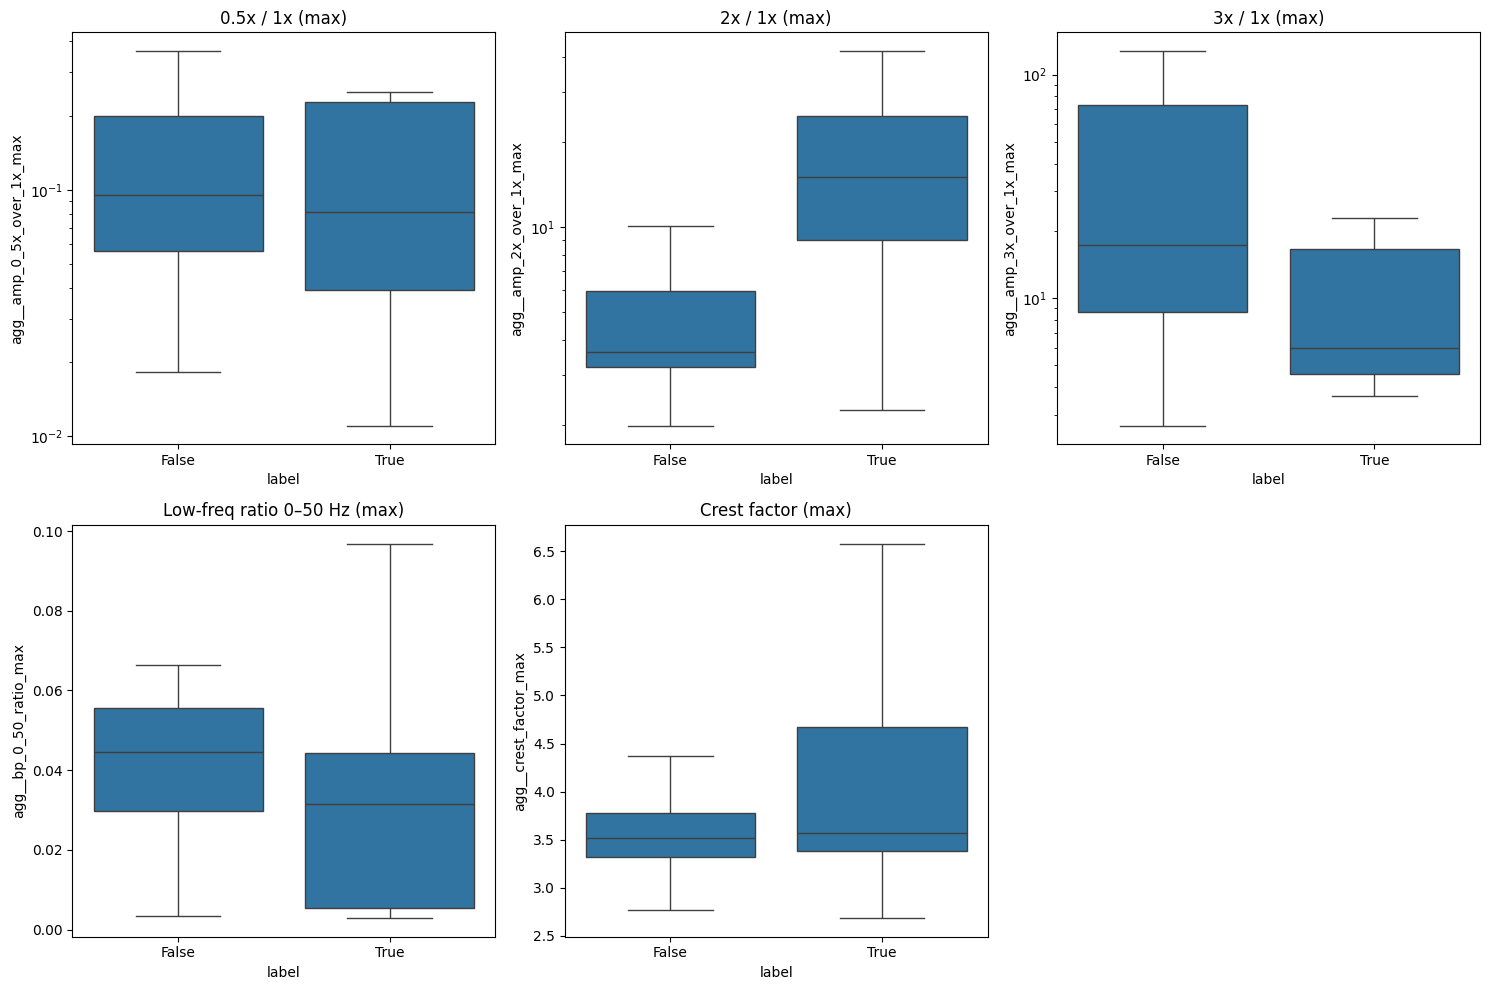

In [25]:
metrics = [
    ("agg__amp_0_5x_over_1x_max", "0.5x / 1x (max)"),
    ("agg__amp_2x_over_1x_max",   "2x / 1x (max)"),
    ("agg__amp_3x_over_1x_max",   "3x / 1x (max)"),
    ("agg__bp_0_50_ratio_max",    "Low-freq ratio 0–50 Hz (max)"),
    ("agg__crest_factor_max",     "Crest factor (max)"),
]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, (col, title) in enumerate(metrics):
    ax = axes[i]
    sns.boxplot(data=features_df, x="label", y=col, ax=ax, showfliers = False)
    ax.set_title(title)
    ax.set_xlabel("label")
    ax.set_ylabel(col)

    # Log scale for heavy-tailed ratio metrics
    if "over_1x" in col:
        ax.set_yscale("log")

# Turn off the unused 6th subplot
axes[-1].axis("off")

plt.tight_layout()
plt.show()


### 6.2.2 Statistical Summary

In [27]:
cols = [
    "agg__amp_0_5x_over_1x_max",
    "agg__amp_2x_over_1x_max",
    "agg__amp_3x_over_1x_max",
    "agg__bp_0_50_ratio_max",
    "agg__crest_factor_max",
]

summary = (
    features_df
    .groupby("label")[cols]
    .agg(["median", "std", "mean", "count"])
)

summary



agg__amp_0_5x_over_1x_max                               \
                         median         std       mean count   
label                                                          
False                  0.094854  115.853045  19.543592    81   
True                   0.081119   21.141667   7.359732   169   

      agg__amp_2x_over_1x_max                                \
                       median         std        mean count   
label                                                         
False                3.632321  384.320675   69.428006    81   
True                15.073309  407.315790  144.548252   169   

      agg__amp_3x_over_1x_max                                 \
                       median          std        mean count   
label                                                          
False               17.363344   768.471841  185.680521    81   
True                 5.963247  3148.306771  982.132712   169   

      agg__bp_0_50_ratio_max                           agg__crest_factor_max  \
                      median       std      mean count                median   
label                                                                          
False               0.044433  0.127765  0.077488    81              3.520130   
True                0.031502  0.192437  0.108084   169              3.567759   

                                 
            std      mean count  
label                            
False  0.414620  3.536816    81  
True   0.917423  4.058310   169

### 6.2.3 Statistical Hypothesis Testing — Feature Discrimination Between Healthy and Looseness

* Objective

This section evaluates whether the differences observed between healthy and looseness samples are statistically significant.

Boxplots provide visual evidence of separation, but hypothesis testing allows us to verify whether these differences are likely due to underlying physical effects rather than random variation.

---

* Hypotheses

For each feature:

- **H₀:** The feature distribution is the same for healthy and looseness samples.
- **H₁:** The feature distribution differs between classes.

---

* Testing Strategy

Given that harmonic ratios tend to be skewed:

- Log transformation is applied when appropriate.
- If normality is approximately satisfied → Welch’s t-test is used.
- Otherwise → Mann–Whitney U test (non-parametric).

Multiple comparisons are adjusted using FDR (Benjamini–Hochberg).

---

* Interpretation

Significant p-values indicate statistical separation between classes.  
Effect size quantifies the magnitude of that separation.


In [33]:
cols = [
    "agg__amp_0_5x_over_1x_max",
    "agg__amp_2x_over_1x_max",
    "agg__amp_3x_over_1x_max",
    "agg__bp_0_50_ratio_max",
    "agg__crest_factor_max",
]

def _safe_array(s: pd.Series) -> np.ndarray:
    x = s.astype(float).to_numpy()
    x = x[np.isfinite(x)]
    return x

def _maybe_transform(col: str, x: np.ndarray) -> tuple[np.ndarray, str]:
    # Log-transform for harmonic ratios (heavy-tailed, positive)
    if "over_1x" in col:
        return np.log1p(np.clip(x, a_min=0, a_max=None)), "log1p"
    return x, "none"

def _shapiro_p(x: np.ndarray, max_n: int = 5000) -> float:
    # Shapiro is sensitive and can be slow; sample if large
    if x.size > max_n:
        idx = np.random.choice(x.size, size=max_n, replace=False)
        x = x[idx]
    # Shapiro requires at least 3 points
    if x.size < 3:
        return np.nan
    return float(stats.shapiro(x).pvalue)

def _cohen_d(x: np.ndarray, y: np.ndarray) -> float:
    # Standardized mean difference (useful for Welch context)
    nx, ny = x.size, y.size
    if nx < 2 or ny < 2:
        return np.nan
    vx, vy = np.var(x, ddof=1), np.var(y, ddof=1)
    s = np.sqrt(((nx - 1) * vx + (ny - 1) * vy) / (nx + ny - 2))
    return float((np.mean(x) - np.mean(y)) / s) if s > 0 else np.nan

def _cliffs_delta(x: np.ndarray, y: np.ndarray) -> float:
    # Effect size for Mann–Whitney (robust, interpretable)
    # delta = P(x>y) - P(x<y)
    if x.size == 0 or y.size == 0:
        return np.nan
    # For performance, sample if too big
    max_n = 5000
    if x.size > max_n:
        x = np.random.choice(x, size=max_n, replace=False)
    if y.size > max_n:
        y = np.random.choice(y, size=max_n, replace=False)
    # Compute pairwise comparisons
    gt = 0
    lt = 0
    for xi in x:
        gt += np.sum(xi > y)
        lt += np.sum(xi < y)
    n = x.size * y.size
    return float((gt - lt) / n)

rows = []
for col in cols:
    x_raw = _safe_array(features_df.loc[features_df["label"] == False, col])
    y_raw = _safe_array(features_df.loc[features_df["label"] == True,  col])

    x, tr = _maybe_transform(col, x_raw)
    y, _  = _maybe_transform(col, y_raw)

    # Normality check after transform
    px = _shapiro_p(x)
    py = _shapiro_p(y)
    normal = (px > 0.05) and (py > 0.05)

    if normal:
        # Welch t-test (unequal variances)
        test = stats.ttest_ind(y, x, equal_var=False, nan_policy="omit")
        pval = float(test.pvalue)
        stat = float(test.statistic)
        method = "Welch t-test"
        effect = _cohen_d(y, x)  # (True - False) in transformed scale
        effect_name = "Cohen's d (True-False)"
    else:
        # Mann-Whitney U (two-sided)
        # Use alternative='two-sided' (SciPy >=1.7)
        test = stats.mannwhitneyu(y, x, alternative="two-sided")
        pval = float(test.pvalue)
        stat = float(test.statistic)
        method = "Mann–Whitney U"
        effect = _cliffs_delta(y, x)  # (True vs False)
        effect_name = "Cliff's delta (True vs False)"

    rows.append({
        "feature": col,
        "transform": tr,
        "n_false": int(x_raw.size),
        "n_true": int(y_raw.size),
        "median_false": float(np.median(x_raw)) if x_raw.size else np.nan,
        "median_true": float(np.median(y_raw)) if y_raw.size else np.nan,
        "std_false": float(np.std(x_raw, ddof=1)) if x_raw.size > 1 else np.nan,
        "std_true": float(np.std(y_raw, ddof=1)) if y_raw.size > 1 else np.nan,
        "shapiro_p_false": px,
        "shapiro_p_true": py,
        "test": method,
        "stat": stat,
        "p_value": pval,
        effect_name: effect,
    })

# FDR (Benjamini–Hochberg)
rej, p_adj, _, _ = multipletests(results["p_value"].values, alpha=0.05, method="fdr_bh")
results["p_value_fdr_bh"] = p_adj
results["reject_fdr_bh_0_05"] = rej
display(results)



,feature,transform,n_false,n_true,median_false,median_true,std_false,std_true,shapiro_p_false,shapiro_p_true,test,stat,p_value,Cliff's delta (True vs False),p_value_fdr_bh,reject_fdr_bh_0_05
1,agg__amp_2x_over_1x_max,log1p,81,169,3.632321,15.073309,384.320675,407.315790,2.127364e-13,7.584132e-16,Mann–Whitney U,11558.0,1.276745e-18,0.688655,6.383723e-18,True
2,agg__amp_3x_over_1x_max,log1p,81,169,17.363344,5.963247,768.471841,3148.306771,3.380774e-07,9.987470e-18,Mann–Whitney U,4670.0,4.848369e-05,-0.317700,1.212092e-04,True
4,agg__crest_factor_max,none,81,169,3.520130,3.567759,0.414620,0.917423,2.991254e-03,3.171049e-12,Mann–Whitney U,8801.0,2.567658e-04,0.285850,4.163101e-04,True
3,agg__bp_0_50_ratio_max,none,81,169,0.044433,0.031502,0.127765,0.192437,3.055263e-16,2.729581e-20,Mann–Whitney U,4924.0,3.330481e-04,-0.280590,4.163101e-04,True
0,agg__amp_0_5x_over_1x_max,log1p,81,169,0.094854,0.081119,115.853045,21.141667,1.017953e-16,3.273666e-20,Mann–Whitney U,6212.0,2.375648e-01,-0.092410,2.375648e-01,False


### 6.2.4 Bivariate Harmonic Analysis — 2×/1× vs 3×/1×


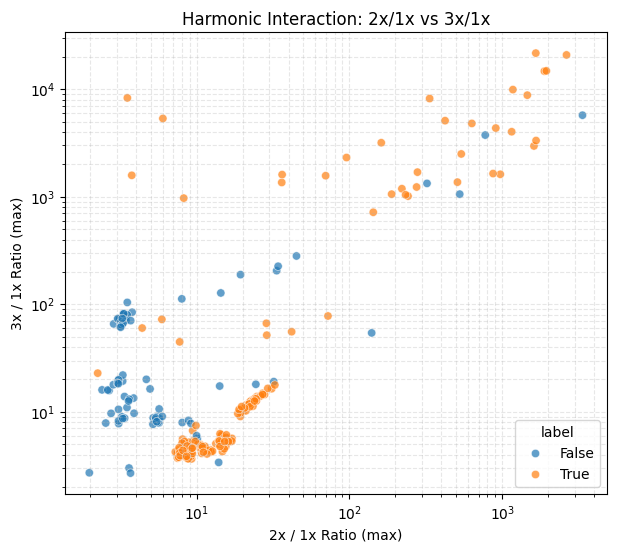

In [34]:
plt.figure(figsize=(7,6))

sns.scatterplot(
    data=features_df,
    x="agg__amp_2x_over_1x_max",
    y="agg__amp_3x_over_1x_max",
    hue="label",
    alpha=0.7
)

plt.xscale("log")
plt.yscale("log")

plt.xlabel("2x / 1x Ratio (max)")
plt.ylabel("3x / 1x Ratio (max)")
plt.title("Harmonic Interaction: 2x/1x vs 3x/1x")
plt.grid(True, which="both", linestyle="--", alpha=0.3)

plt.show()


## 3.6 Discriminative Analysis Summary and Modeling Implications

The exploratory analysis reveals consistent and statistically validated separation between healthy and structural looseness samples.

### Key Findings

1. **2×/1× Harmonic Ratio**
   - Strong visual separation in boxplots.
   - Highly significant statistical difference (p ≪ 0.001).
   - Large effect size (Cliff’s delta ≈ 0.69).
   - Clear separation along the X-axis in the scatter plot.

   → This is the most discriminative feature and aligns with the physical expectation that looseness amplifies harmonic distortion at multiples of rotational frequency.

2. **3×/1× Harmonic Ratio**
   - Statistically significant but with smaller effect size.
   - Behavior partially inverted relative to 2×.
   - Provides complementary discriminative information.

3. **Crest Factor**
   - Statistically significant but modest effect size.
   - Likely secondary contributor.

4. **Low-Frequency Band Ratio (0–50 Hz)**
   - Statistically significant but not aligned with classical expectation.
   - Healthy samples show slightly higher median values.
   - Not a primary driver for discrimination in this dataset.

5. **0.5× Sub-harmonic**
   - Not statistically significant.
   - Does not contribute meaningfully to class separation.
   - Suggests that looseness in this test bench manifests predominantly through harmonic amplification rather than sub-harmonic nonlinear behavior.

---

### Physical Interpretation

The dominant discriminative mechanism appears to be:

> Amplification of the second harmonic (2×) relative to the fundamental rotational frequency (1×).

This suggests that structural looseness in the laboratory setup introduces harmonic distortion rather than broadband low-frequency excitation or sub-harmonic generation.

---

### Modeling Strategy Anchored in Evidence

Based on the statistical and visual evidence:

1. The 2×/1× ratio will be the primary predictive feature.
2. 3×/1× may provide complementary information.
3. A linear decision boundary appears plausible from the scatter plot.
4. A simple physics-informed threshold baseline should be tested before complex models.

The modeling roadmap therefore becomes:

- Step 1: Physics-based threshold baseline using 2×/1×.
- Step 2: Logistic Regression using harmonic ratios.
- Step 3: Evaluate ROC-AUC, PR-AUC, and confusion matrix.
- Step 4: Introduce nonlinear models only if necessary.

The objective is not to maximize complexity, but to achieve physically interpretable and robust classification performance.


## 6.3 Bivariate: interactions (harmonics × low-freq)

## 6.4 What would justify model complexity?